# Assignment: Classification

Classification refers to categorizing the given data into classes. For example,
- Given an image of hand-written character, identifying the character (multi-class classification)
- Given an image, annotating it with all the objects present in the image (multi-label classification)
- Classifying an email as spam or non-spam (binary classification)
- Classifying a tumor as benign or malignant and so on

In this assignment, we will be building a classifier to classify emails as spam or non-spam. We will be using the Kaggle dataset [Spam or Not Spam Dataset](https://www.kaggle.com/datasets/ozlerhakan/spam-or-not-spam-dataset?resource=download) for this task. 

**Note**: You cannot load any libraries other than the mentioned ones.




### Data pre-processing
The first step in every machine learning algorithm is to process the raw data in some meaningful representations. We will be using the [Bag-of-Words](https://towardsdatascience.com/a-simple-explanation-of-the-bag-of-words-model-b88fc4f4971) representation to process the text. It comprises of following steps:

- Process emails line-by-line to extract all the words.
- Replace extracted words by their stem (root) word. This is known as stemming and lematization.
- Remove stop words like and, or, is, am, and so on.
- Assign a unique index to each word. This forms the vocabulary.
- Represent each email as a binary vector of length equal to the size of the vocabulary such that the $i^{th}$ element of the vector is 1 iff the $i^{th}$ word is present in the email.

Here we provide you with the function signature along with the expected functionality. You are expected to complete them accordingly. 

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/yashbg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import numpy as np
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# takes an email as an argument
# read email line-by-line and extract all the words
# return list of extracted words
def read_email(email):
  email = email.replace('_', '')
  words = list(set(email.split()))
  return words
  
# takes a list of words as an argument
# replace each word by their stem word
# return list of stem words
def stemming(words):
  stemmer = PorterStemmer()
  stem_words = [stemmer.stem(word) for word in words]
  return stem_words

# takes a list of stem-words as an argument
# remove stop words
# return list of stem words after removing stop words
def remove_stop_words(stem_words):
  stem_no_stop_words = [word for word in stem_words if word not in stopwords.words('english')]
  return stem_no_stop_words

# takes a list of stem-words as an argument
# add new words to the vocabulary and assign a unique index to them
# returns new vocabulary
def build_vocabulary(stem_words, vocab):
  new_vocab = vocab
  for word in stem_words:
    if word not in new_vocab:
      new_vocab.append(word)
  return new_vocab

# takes a list of stem-words and vocabulary as an argument
# returns bow representation
def get_bow(email, vocab):
  email_bow = np.zeros_like(vocab, dtype=bool)
  words = read_email(email)
  stem_words = remove_stop_words(stemming(words))

  for word in stem_words:
    email_bow[vocab.index(word)] = True
  return email_bow

# read the entire dataset
# convert emails to bow and maintain their labels
# call function text_to_bow()
def read_data(data_file):
  with open(data_file) as f:
    next(f)
    lines = f.readlines()
    n = len(lines)

    vocab = []
    for line in lines:
      email, label = line.split(',')
      words = read_email(email)
      stem_words = remove_stop_words(stemming(words))
      vocab = build_vocabulary(stem_words, vocab)

    data = np.empty((n, len(vocab) + 1), dtype=bool)
    for i, line in enumerate(lines):
      email, label = line.split(',')
      label = bool(int(label.strip()))
      bow = get_bow(email, vocab)
      data[i, :-1] = bow
      data[i, -1] = label 
  return data, vocab

In [4]:
data, vocab = read_data('spam_or_not_spam.csv')

In [5]:
data.shape

(3000, 25430)

### Data Visualization
Let's understand the data distribution
- Visualize the frequency of word-occurence in all the emails(spam + non-spam)
- Visualize the frequency of word-occurence for spam and non-spam emails separately

No. of All emails: 3000


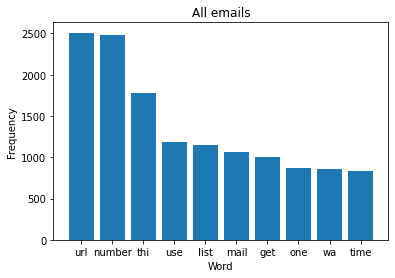

No. of Spam emails: 500


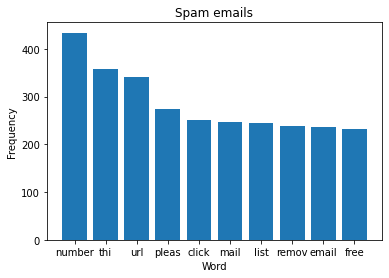

No. of Non-spam emails: 2500


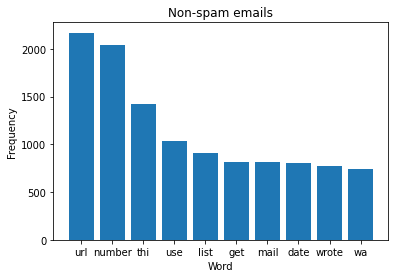

In [66]:
import matplotlib.pyplot as plt

def plot_emails(emails, len_top_words, email_type):
  print(f'No. of {email_type}: {len(emails)}')
  top_idx = np.argsort(emails.sum(axis=0))[::-1][:len_top_words]
  plt.bar(range(len_top_words), emails.sum(axis=0)[top_idx])
  plt.xticks(range(len_top_words), np.array(vocab)[top_idx])
  plt.title(email_type)
  plt.xlabel('Word')
  plt.ylabel('Frequency')
  plt.show()

# visuallze data distribution
def data_vis(data):
  len_top_words = 10

  emails = data[:, :-1]
  plot_emails(emails, len_top_words, 'All emails')

  emails_spam = data[data[:, -1] == True][:, :-1]
  plot_emails(emails_spam, len_top_words, 'Spam emails')

  emails_non_spam = data[data[:, -1] == False][:, :-1]
  plot_emails(emails_non_spam, len_top_words, 'Non-spam emails')
  return

data_vis(data)

### Learn a Classifier
Split the dataset randomly in the ratio 80:20 as the training and test dataset. Use only training dataset to learn the classifier. No test data should be used during training. Test data will only be used during evaluation.

Now let us try to use ML algorithms to classify emails as spam or non-spam. You are supposed to implement [SVM](https://scikit-learn.org/stable/modules/svm.html) and [K-Nearest Neighbour](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) algorithm available in scikit-learn using the same training dataset for both.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# split dataset
def split(data):
  n = len(data)
  train_size = int(0.8 * n)
  train_idx = np.random.choice(n, train_size, replace=False)
  train_data = []
  test_data = []
  for i, row in enumerate(data):
    if i in train_idx:
      train_data.append(row)
    else:
      test_data.append(row)
  return np.array(train_data), np.array(test_data)

# learn a SVM model
# use the model to make prediction
# return the model predictions on train and test dataset
def svm_classifier(train_data, test_data):
  X_train, y_train = train_data[:, :-1], train_data[:, -1]
  X_test, y_test = test_data[:, :-1], test_data[:, -1]

  clf = svm.SVC()
  clf.fit(X_train, y_train)
  train_predictions = clf.predict(X_train)
  test_predictions = clf.predict(X_test)
  return train_predictions, test_predictions

# implement k-NN algorithm
# use the model to make prediction
# return the model predictions on train and test dataset
def knn_classifier(train_data, test_data):
  X_train, y_train = train_data[:, :-1], train_data[:, -1]
  X_test, y_test = test_data[:, :-1], test_data[:, -1]

  neigh = KNeighborsClassifier()
  neigh.fit(X_train, y_train)
  train_predictions = neigh.predict(X_train)
  test_predictions = neigh.predict(X_test)
  return train_predictions, test_predictions

train_data, test_data = split(data)
svm_train_predictions, svm_test_predictions = svm_classifier(train_data, test_data)
knn_train_predictions, knn_test_predictions = knn_classifier(train_data, test_data)

### Model Evaluation
Compare the SVM and k-NN model using metrics
- Accuracy
- [AUC score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html)


In [ ]:
from sklearn import metrics

# compute accuracy 
def compute_accuracy(true_labels, predicted_labels):
  acc = metrics.accuracy_score(true_labels, predicted_labels)
  return acc

# compute AUC score 
def compute_auc(true_labels, predicted_labels):
  fpr, tpr, thresholds = metrics.roc_curve(true_labels, predicted_labels)
  auc = metrics.auc(fpr, tpr)
  return auc

# write code to print train and test accuracy and AUC score of SVM and k-NN classifier
X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_test, y_test = test_data[:, :-1], test_data[:, -1]

svm_train_acc = compute_accuracy(y_train, svm_train_predictions)
svm_test_acc = compute_accuracy(y_test, svm_test_predictions)

svm_train_auc = compute_auc(y_train, svm_train_predictions)
svm_test_auc = compute_auc(y_test, svm_test_predictions)

knn_train_acc = compute_accuracy(y_train, knn_train_predictions)
knn_test_acc = compute_accuracy(y_test, knn_test_predictions)

knn_train_auc = compute_auc(y_train, knn_train_predictions)
knn_test_auc = compute_auc(y_test, knn_test_predictions)

print('SVM Classifier:')
print()

print('Accuracies:')
print(f'Train = {svm_train_acc}')
print(f'Test = {svm_test_acc}')
print()

print('AUC scores:')
print(f'Train = {svm_train_auc}')
print(f'Test = {svm_test_auc}')
print()
print()

print('k-NN Classifier:')
print()

print('Accuracies:')
print(f'Train = {knn_train_acc}')
print(f'Test = {knn_test_acc}')
print()

print('AUC scores:')
print(f'Train = {knn_train_auc}')
print(f'Test = {knn_test_auc}')

SVM Classifier:

Accuracies:
Train = 0.9945833333333334
Test = 0.9766666666666667

AUC scores:
Train = 0.9839506172839506
Test = 0.9263157894736842


k-NN Classifier:

Accuracies:
Train = 0.8279166666666666
Test = 0.7533333333333333

AUC scores:
Train = 0.8709087533648937
Test = 0.8192808754559666
